# Single qubit proof of concept GST from experimental data

In [10]:
# Note: I removed the mGST folders from within the qibocal fork, such that it is installed and updated seperately
from mGST import compatibility,algorithm, optimization, low_level_jit, additional_fns

In [11]:
import pickle as pickle
import pandas as pd
from pygsti.report import reportables as rptbl #Needs cvxpy!
from pygsti.modelpacks import smq1Q_XYI as std
from argparse import Namespace
import numpy as np

In [12]:
print('\n'.join(f'{m.__name__}=={m.__version__}' for m in globals().values() if getattr(m, '__version__', None)))

pandas==1.4.1
numpy==1.21.6


### Setting the parameters

In [13]:
pdim = 2   # physical dimension
r = pdim**2   # rank of the gate superoperators 

l = 7  # maximum number of gates in each measurement sequence
d = 3  # number of gates
# rK = 4   # rank of the model estimate
n_povm = 2   # number of POVM-elements

N = 500
meas_samples = 1e4

### Loading data from csv

In [14]:
data = pd.read_csv(r'compressive_gst.csv')
y0 = data['probability0'].to_numpy()
y = np.array([y0,1-y0])
J = np.array([np.fromstring(data['circuit'][i].strip('[]'), dtype = int, sep = ',') for i in range(N)])

### GST

In [9]:
bsize = 50   # The batch size on which the optimization is started
results = []
for rK in range(1,5):
    X_t,E_t,rho_t = compatibility.pygsti_model_to_arrays(std.target_model(),basis = 'std') #The idle-X(pi/w)-Y(pi/2) model 
    K_t = additional_fns.Kraus_rep(X_t,d,pdim,rK)
    X_t = np.einsum('ijkl,ijnm -> iknlm', K_t, K_t.conj()).reshape(d,r,r)  
    K,X,E,rho,res_list_batch = algorithm.run_mGST(y,J,l,d,r,rK, n_povm, bsize, meas_samples, method = 'SFN',
                         max_inits = 20, max_iter = 50, final_iter = 40, threshold_multiplyer = 30, 
                         target_rel_prec = 1e-4, init = [K_t,E_t,rho_t], testing = True)   
    results.append([K,X,E,rho])

Starting optimization...
 32%|█████████████▊                             | 16/50 [00:27<00:59,  1.74s/it]
Optimization successful, improving estimate over full data....
 15%|██████▌                                     | 6/40 [00:22<02:06,  3.71s/it]
#################
	 Convergence criterion satisfied
	 Final objective function value 0.00014310808586431322 with # of initializations: 1 
 	 Total runtime: 50.6821494102478
Starting optimization...
  8%|███▌                                        | 4/50 [00:01<00:13,  3.35it/s]
Optimization successful, improving estimate over full data....
 42%|██████████████████▎                        | 17/40 [00:15<00:21,  1.06it/s]
#################
	 Convergence criterion satisfied
	 Final objective function value 0.00016521351363420496 with # of initializations: 1 
 	 Total runtime: 17.192070484161377
Starting optimization...
 16%|███████                                     | 8/50 [00:03<00:17,  2.43it/s]
Optimization successful, improving estimate ov

###  Saving data

In [11]:
###################################### 
# filename = 'ranks_1_4_full_data_from_init'
# parameters = {'sequence length':l,'gate count':d,'Kraus ranks':[1,2,3,4],'phys. dimension':int(np.sqrt(r)), 'Sequence count': N, 
#               'J':J,'y':y,'threshold_multiplyer': 30, 
#                      'target_rel_prec':1e-4}
# data_to_safe = {'parameters':parameters, 'results':results}

# with open(filename, 'wb') as handle:
#     pickle.dump(data_to_safe, handle, protocol=pickle.HIGHEST_PROTOCOL)

## Analysis of results and comparison over different runs

In [17]:
with open("ranks_1_4_full_data_from_init", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [18]:
MVE_list = []
povm_td_list = []
rho_td_list = []
F_avg_list = []
DD_list = []
for i in range(len(results)):
    X,E,rho = results[i][1:]
    mdl = arrays_to_pygsti_model(X,E,rho, basis = 'std')
    X_t,E_t,rho_t = pygsti_model_to_arrays(std.target_model(),basis = 'std')
    target_mdl = arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std') #For consistent gate labels

    gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
                target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, basis = 'pp'),
                item_weights={'G0': 1,'G1': 1, 'G2': 1, 'spam': 1})
    X_opt,E_opt,rho_opt = pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')

    MVE_list.append(MVE(X_t,E_t,rho_t,X,E,rho,d,l, n_povm)[0])
    povm_td_list.append(rptbl.povm_jtrace_diff(target_mdl, gauge_optimized_mdl, 'Mdefault'))
    rho_td_list.append(la.norm(rho_opt-rho_t,ord = 1)/2)
    F_avg_list.append(average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
    DD_list.append(diamond_dists(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
    print('Total variation error between model probabilites and measured probabilites (goodness of fit):', rho_td_list[-1])
    print('Mean variation error between GST-model probabilities and target model probabilities:', MVE_list[-1])   # output the final mean variation error
    print('Initial state error in trace distance:', rho_td_list[-1])
    print('Choi matrix trace distance of the measurement map:',povm_td_list[-1])
    print('Average gate fidelities:',F_avg_list[-1])
    print('Diamond distances:',DD_list[-1])
    print('\n')

Total variation error between model probabilites and measured probabilites (goodness of fit): 0.08446669343064618
Mean variation error between GST-model probabilities and target model probabilities: 0.044625168861381743
Initial state error in trace distance: 0.08446669343064618
Choi matrix trace distance of the measurement map: 0.028666874686050777
Average gate fidelities: [0.99999672 0.99995954 0.99996703]
Diamond distances: [0.00221649 0.00779018 0.00703208]


Total variation error between model probabilites and measured probabilites (goodness of fit): 0.014228750982740422
Mean variation error between GST-model probabilities and target model probabilities: 0.044036727323747686
Initial state error in trace distance: 0.014228750982740422
Choi matrix trace distance of the measurement map: 0.012587991063289833
Average gate fidelities: [0.99159996 0.98313685 0.98286903]
Diamond distances: [0.01349505 0.02837346 0.02692042]


Total variation error between model probabilites and measured pr

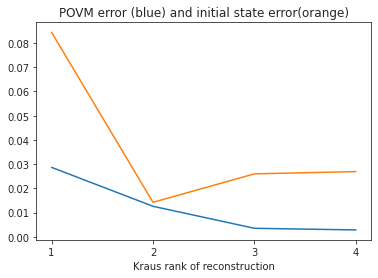

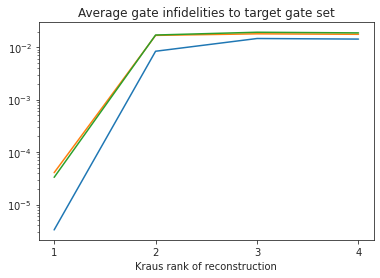

In [26]:
plt.plot(povm_td_list)
plt.plot(rho_td_list)
plt.title('POVM error (blue) and initial state error(orange)')
plt.xlabel('Kraus rank of reconstruction')
plt.xticks(ticks = np.arange(4), labels = np.arange(4)+1)
plt.show()

plt.semilogy(1-np.array(F_avg_list))
plt.title('Average gate infidelities to target gate set')
plt.xlabel('Kraus rank of reconstruction')
plt.xticks(ticks = np.arange(4), labels = np.arange(4)+1)
plt.show()

## Comparing low rank GST with low rank approximations to high rank GST

In [20]:
rK_approx = 1
F_avg_list_proj = []
DD_list_proj = []
for i in range(4):
    K,X,E,rho = results[i]
    K_proj = Kraus_rep(X,d,pdim,rK_approx) # gives low rank approximation if rK_approx is small than the actual rank
    X_proj = np.einsum('ijkl,ijnm -> iknlm', K_proj, K_proj.conj()).reshape(d,r,r)  
    mdl = arrays_to_pygsti_model(X_proj,E,rho, basis = 'std')
    
    X_t,E_t,rho_t = pygsti_model_to_arrays(std.target_model(),basis = 'std')
    target_mdl = arrays_to_pygsti_model(X_t,E_t,rho_t, basis = 'std')

    gauge_optimized_mdl = pygsti.algorithms.gaugeopt_to_target(mdl, 
                target_mdl,gauge_group = pygsti.models.gaugegroup.UnitaryGaugeGroup(target_mdl.state_space, 'pp'),
                item_weights={'G0': 1,'G1': .1, 'G2': 1, 'spam': 1})

    X_opt,E_opt,rho_opt = pygsti_model_to_arrays(gauge_optimized_mdl,basis = 'std')

    F_avg_list_proj.append(average_gate_fidelities(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
    DD_list_proj.append(diamond_dists(gauge_optimized_mdl,target_mdl,pdim, basis_string = 'pp'))
    print('Rank %i-reconstruction:'%(i+1))
    print('Average gate fidelities:',F_avg_list_proj[-1])
    print('Diamond distances:',DD_list_proj[-1])
    print('\n')

Rank 1-reconstruction:
Average gate fidelities: [0.99999672 0.99995269 0.9999675 ]
Diamond distances: [0.00221649 0.00842391 0.00698215]


Rank 2-reconstruction:
Average gate fidelities: [0.99999838 0.99996666 0.999979  ]
Diamond distances: [0.00180036 0.00791571 0.0057281 ]


Rank 3-reconstruction:
Average gate fidelities: [0.99999495 0.99978626 0.99985587]
Diamond distances: [0.00363015 0.02357319 0.01903445]


Rank 4-reconstruction:
Average gate fidelities: [0.99999493 0.99981551 0.99985844]
Diamond distances: [0.00331695 0.02144282 0.01890631]




## Full rank results

In [15]:
with open("full_rank_full_data", 'rb') as handle:
    b = pickle.load(handle)
results = b['results']

In [16]:
### Results for 10 runs of full rank optimization without initialization
print('Average and standard deviation of average gate fidelites (average over 10 GST runs):')
print(np.average(np.array(F_avg_list), axis = 0))
print(np.std(np.array(F_avg_list), axis = 0))
print('Average and standard deviation of diamond norms:')
print(np.average(np.array(DD_list), axis = 0))
print(np.std(np.array(DD_list), axis = 0))
print('Avg. and std. of mean variation error:')
print(np.average(np.array(MVE_list), axis = 0))
print(np.std(np.array(MVE_list), axis = 0))

Average and standard deviation of average gate fidelites (average over 10 GST runs):
[0.99064168 0.98683887 0.98616638]
[0.00595156 0.00758746 0.00800997]
Average and standard deviation of diamond norms:
[0.01567344 0.03355419 0.03610764]
[0.00879068 0.01737143 0.02038819]
Avg. and std. of mean variation error:
0.04366526646489639
0.00031336505374647886


### Things to check out:
- Run on first 50/100 sequences, then on next 50/100 etc. to see changes over time in the experiment